In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from surprise import KNNWithMeans
from surprise import Dataset,Reader
from surprise import accuracy
%matplotlib inline

from surprise.model_selection import train_test_split

In [2]:
# Loading the complete data results memmory error while fitting the KNN model, so out of 7800000, 6000000 rows loded for performing
dataframe = pd.read_csv("./ratings_Electronics.csv",nrows=6000000)
dataframe.drop(dataframe.columns[3], axis=1, inplace=True)
dataframe.columns = ['userId','productId','RatingUser']
dataframe.info(verbose=False, memory_usage="deep")
dataframe.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Columns: 3 entries, userId to RatingUser
dtypes: float64(1), object(2)
memory usage: 833.9 MB


userId         object
productId      object
RatingUser    float64
dtype: object

# Converting the data types for the memory optimization

In [3]:
dataframe['userId'] = dataframe['userId'].astype('category')
dataframe['productId'] = dataframe['productId'].astype('category')
dataframe['RatingUser'] = dataframe['RatingUser'].astype('float16')
dataframe.head()

,userId,productId,RatingUser
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [4]:
dataframe.dtypes

userId        category
productId     category
RatingUser     float16
dtype: object

In [5]:
dataframe.info(verbose=False, memory_usage="deep")
# The memory usage is reduced in to 478.0 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Columns: 3 entries, userId to RatingUser
dtypes: category(2), float16(1)
memory usage: 478.0 MB


In [6]:
# No null values has observed
dataframe.isnull().sum()

userId        0
productId     0
RatingUser    0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000287169DA048>]],
      dtype=object)

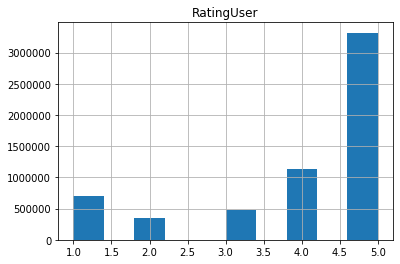

In [7]:
# Checking the user rating column, Identifying the frequency od user rating
dataframe.hist(dataframe.columns[2])

In [8]:
# Checking the size of the dataframe
dataframe.shape

(6000000, 3)

# Selecting the userId's that they have rated 50 times or more.

In [9]:
# avoidSamevalues =[]
# sortedValues = []
# for userid in dataframe['userId']:
#     if(userid not in avoidSamevalues):
#         avoidSamevalues.append(userid)
#         idcount = dataframe[dataframe['userId'] == userid].userId.count()
#         if(idcount>=50):  # Specifies the number of times the user is given ratings
# #             print(idcount, userid)
#             sortedValues.append(userid)
# print(sortedValues)    
counts = dataframe['userId'].value_counts()
dataframe = dataframe[dataframe['userId'].isin(counts[counts>50].index)]

In [10]:
# Checking the size of the dataframe after filtering the users who rated 50 times or more
dataframe.shape

(66188, 3)

# Popularity recomendation model

In [11]:
print('\nHiglighting the product ids who rated high in decending order')
print('\n',dataframe.groupby('productId')['RatingUser'].mean().sort_values(ascending=False).head(10))

print('\nHilighting the product based on number of times rated')
print(dataframe.groupby('userId')['RatingUser'].count().sort_values(ascending = False).head(10))


Higlighting the product ids who rated high in decending order

 productId
B0080E1SIQ    5.0
B002WJ9S6Y    5.0
B002WSPHBA    5.0
B002WSPAKI    5.0
B000BGOSRE    5.0
B000BGZMSI    5.0
B002WRGD96    5.0
B002WR7VSS    5.0
B002WQFWTY    5.0
B000BGZMTC    5.0
Name: RatingUser, dtype: float16

Hilighting the product based on number of times rated
userId
A5JLAU2ARJ0BO     500
A3OXHLG6DIBRW8    419
A6FIAB28IS79      411
ADLVFFE4VBT8      357
A680RUE1FDO8B     337
A2AY4YUOX2N1BQ    267
A231WM2Z2JL0U3    252
A1ODOGXEYECQQ8    248
A203OCQQ12MAVT    239
A17BUUBOU0598B    228
Name: RatingUser, dtype: int64


In [12]:
recommendationModel = pd.DataFrame(dataframe.groupby('productId')['RatingUser'].mean().sort_values(ascending = False))
recommendationModel['RatingCount']= pd.DataFrame(dataframe.groupby('productId')['RatingUser'].count())
# recommendationModel['userID']= pd.DataFrame(dataframe.groupby('productId')['userId'])

In [13]:
# The bwlow recoomendation model is based on product ID's shown first having highest user ratings
recommendationModel # popularity based sorting

,RatingUser,RatingCount
productId,,
B0080E1SIQ,5.0,1
B002WJ9S6Y,5.0,1
B002WSPHBA,5.0,1
B002WSPAKI,5.0,1
B000BGOSRE,5.0,1
...,...,...
B0080E2J34,NaN,0
B0080E2JDO,NaN,0
B0080E2K88,NaN,0


In [14]:
# The above popularity model is based on the user rating

# Splitting the data in to training and testing set

In [15]:
reader = Reader()
data = Dataset.load_from_df(dataframe, reader)

trainset, testset = train_test_split(data, test_size=.3) # Training set is 70% & Testing set is 30%

# Collaborative Filtering Model 
# User based

In [16]:
algouser = KNNWithMeans(k=50, sim_options = {'name':'cosine', 'user_based': True})
algouser .fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [17]:
userid = str('A243HY69GIAHFI')
productid = str('B0000226QJ')

In [18]:
preduser = algouser.predict(userid,productid, verbose = True)

user: A243HY69GIAHFI item: B0000226QJ r_ui = None   est = 4.25   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}


In [19]:
testprduser = algouser.test(testset)
testprduser

[Prediction(uid='A2AF0NOCM71J0B', iid='B0041L3JS4', r_ui=5.0, est=3.949851040175136, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='A3TRY87JJCA5Y8', iid='B0001WN1D0', r_ui=4.0, est=4.249422632794457, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A36IHC0K68NS2', iid='B002N1J7DU', r_ui=1.0, est=3.765957446808511, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3EXWV8FNSSFL6', iid='B002C2TJR4', r_ui=2.0, est=4.249422632794457, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3UR2N0ATGBCU8', iid='B0062H2KNK', r_ui=4.0, est=4.249422632794457, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1P0JSFW184ZXJ', iid='B003NI5JWK', r_ui=5.0, est=4.249422632794457, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2XQYE6TJYROHQ', iid='B00065HM9Q', r_ui=5.0, est=4.249422632794457, 

# Item Based 

In [20]:
algoitem = KNNWithMeans(k=50, sim_options = {'name':'cosine', 'user_based': False})
algoitem .fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [21]:
userid = str('A243HY69GIAHFI')
productid = str('B0000226QJ')

In [22]:
preditem = algoitem.predict(userid,productid, verbose = True)

user: A243HY69GIAHFI item: B0000226QJ r_ui = None   est = 4.25   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}


In [23]:
testprditem = algoitem.test(testset)
testprditem

[Prediction(uid='A2AF0NOCM71J0B', iid='B0041L3JS4', r_ui=5.0, est=4.110440702897659, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid='A3TRY87JJCA5Y8', iid='B0001WN1D0', r_ui=4.0, est=4.249422632794457, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A36IHC0K68NS2', iid='B002N1J7DU', r_ui=1.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3EXWV8FNSSFL6', iid='B002C2TJR4', r_ui=2.0, est=4.249422632794457, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3UR2N0ATGBCU8', iid='B0062H2KNK', r_ui=4.0, est=4.249422632794457, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1P0JSFW184ZXJ', iid='B003NI5JWK', r_ui=5.0, est=4.249422632794457, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2XQYE6TJYROHQ', iid='B00065HM9Q', r_ui=5.0, est=4.249422632794457, details={'was_im

# Model Performance Comparison

In [24]:
# RMSE Value of item based collaborative filtering
print("User-based Model : Test Set")
accuracy.rmse(testprduser, verbose=True)

User-based Model : Test Set
RMSE: 1.1119


1.1119462465634655

In [25]:
# RMSE Value of item based collaborative filtering
print("User-based Model : Test Set")
accuracy.rmse(testprditem, verbose=True)

User-based Model : Test Set
RMSE: 1.1815


1.181505887503884

# Getting the best predictions

In [26]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0



dataf = pd.DataFrame(testprditem, columns=['uid', 'iid', 'rui', 'est', 'details'])
# dataf = pd.DataFrame(testprditem)
dataf['Iu'] = dataf.uid.apply(get_Iu)
dataf['Ui'] = dataf.iid.apply(get_Ui)
dataf['err'] = abs(dataf.est - dataf.rui)
best_predictions = dataf.sort_values(by='err')[:10]
worst_predictions = dataf.sort_values(by='err')[-10:]

In [27]:
# Lsiting the best 5 nos. of predictions that can be suggested to the users
best_predictions.head()

,uid,iid,rui,est,details,Iu,Ui,err
6844,A2WLNSZ9U0T1S3,B001BLV78Q,5.0,5.0,"{'actual_k': 3, 'was_impossible': False}",130,1,0.0
19006,A15QYHQH80W30L,B005IGVXJS,5.0,5.0,"{'actual_k': 2, 'was_impossible': False}",101,1,0.0
1844,A3EXWV8FNSSFL6,B000J2V65M,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",133,1,0.0
16482,A2T3S3VTW65VO5,B0018BQR84,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",45,3,0.0
19002,A3QMJMTLJC34QC,B003C1AO2I,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",67,3,0.0


In [28]:
# Lsiting the worst 5 nos. of predictions that should be avoided
worst_predictions.head()

,uid,iid,rui,est,details,Iu,Ui,err
1980,A3JV071KO43Q5X,B001UE8KUW,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",44,1,4.0
2356,A1AQ8JT2A3UWMY,B000KI9W74,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",43,1,4.0
9816,A3LGT6UZL99IW1,B000023VUL,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",148,1,4.0
10399,A6XDZ1MJ0B1A2,B004XXMUCQ,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",54,2,4.0
9393,A1L64KDYO5BOJA,B003Y30334,1.0,5.0,"{'actual_k': 2, 'was_impossible': False}",74,1,4.0


# Summery

In [29]:
# Running the model may take more time, when new data adds up.
# Using KNN algoritham here, with bigger datasets complexity and processing capacity should be more
# popularity based can be used for a new website at the begining stage customised recommendation can be delivered to user
# The advantage with model is that No domain knowledge necessary, becausing the embeddings are automatically learned.
# The RMSE for user-user collaborative filtering is : 1.0944467255939307
# The RMSE for item-item collaborative filtering is : 1.1758624183887103